### Bibliotecas

In [26]:
!pip install gymnasium[classic_control]



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import gymnasium as gym
import math
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

### Definindo o ambiente

In [28]:
env = gym.make("CartPole-v1")

### Replay Memory - Guarda as transições que o agente observa

In [29]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Classe que representa a memória de repetição.  
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Método para adicionar transições na memória 
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Método para obter uma amostra de transições da memória  
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Q-Network

In [30]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        # Primeira cada, que recebe o número de observações e retorna 128
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        # Ultima camada, que recebe 128 e retorna o número de ações
        self.layer3 = nn.Linear(128, n_actions)

    # Define o método de propagação da rede
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Hiperparametros e Plots

In [31]:
# Definindo hiperparâmetros  
BATCH_SIZE = 128  # Tamanho do batch para o treinamento  
GAMMA = 0.99  # Fator de desconto  
EPS_START = 0.9  # Valor inicial de epsilon para a estratégia epsilon-greedy  
EPS_END = 0.05  # Valor final de epsilon  
EPS_DECAY = 1000  # Fator de decaimento de epsilon  
TAU = 0.005  # Parâmetro para a atualização suave da rede alvo  
LR = 1e-4  # Taxa de aprendizado  

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

# Criando a rede de políticas e a rede alvo  
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

# Função para selecionar uma ação
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    # Se o número aleatório for maior que o limite de epsilon, seleciona a ação com a maior recompensa esperada  
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1) # Retorna o maior valor de cada coluna, selecionar a coluna com maior recompensa esperada
    else:
        # Se não, seleciona uma ação aleatória 
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

# Função para plotar a duração dos episódios
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Plotando a média de 100 episódios
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Treinamento

In [32]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
     # Seleciona uma amostra da memória do tamanho do lote  
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calcula Q(s_t, a) - o modelo calcula Q(s_t), então selecionamos as  
    # colunas das ações tomadas. Estas são as ações que teriam sido tomadas  
    # para cada estado do lote de acordo com a policy_net  
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calcula V(s_{t+1}) para todos os próximos estados.  
    # Os valores esperados das ações para non_final_next_states são calculados baseados  
    # na "antiga" target_net; selecionando sua melhor recompensa com max(1).values  
    # Isso é mesclado com base na máscara, de modo que teremos o valor de estado esperado  
    # ou 0 no caso de o estado ser final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Calcula os Q valores esperados  
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Calcula a perda Huber 
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Otimiza o modelo 
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


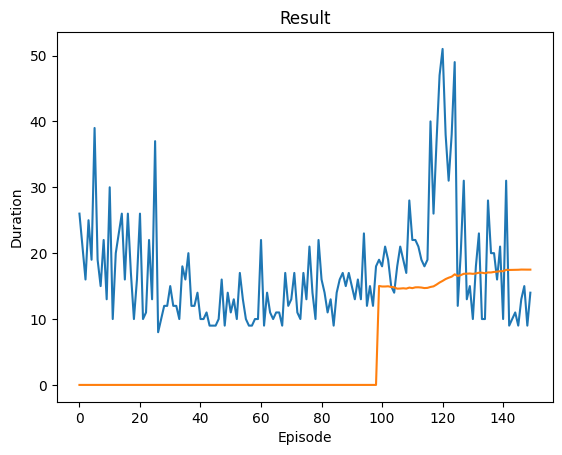

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Inicializa o ambiente e obtém o estado inicial 
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
     # Loop para cada passo do episódio  
    for t in count():
        # Seleciona a ação com base no estado atual  
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

         # Se o episódio terminou, o próximo estado é None  
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Armazena a transição na memória  
        memory.push(state, action, next_state, reward)

        # Move para o próximo estado
        state = next_state

        # Realiza uma etapa da otimização (na rede de política)  
        optimize_model()

        # Atualização suave dos pesos da rede alvo  
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        # Se o episódio terminou, registra a duração e plota as durações 
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()